In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/src')

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import interp1d
from matplotlib.colors import Normalize

from utils.plot_utils import plot_tensor2D, color_2D
from utils.plot_utils import ap_min, ap_max, dv_min, dv_max, dv_midpoint
from utils.plot_utils import residual, mean_norm_residual

lw = 1.5
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 250
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

In [27]:
wt = {}
folder = '../Figures/Forecasting'
wt['folder'] = 'WT'
wt['m0'] = np.load(f'{folder}/m0.npy', mmap_mode='r')
wt['v0'] = np.load(f'{folder}/v0.npy', mmap_mode='r')
wt['c0'] = np.load(f'{folder}/c0.npy', mmap_mode='r')
wt['t0'] = np.load(f'{folder}/time.npy', mmap_mode='r')
wt['m1'] = np.load(f'{folder}/m.npy', mmap_mode='r')
wt['v1'] = np.load(f'{folder}/v.npy', mmap_mode='r')

eve = {}
folder = 'Eve_Mutants'
eve['folder'] = 'Eve'
eve['m0'] = np.load(f'{folder}/ensemble_m0.npy', mmap_mode='r')
eve['v0'] = np.load(f'{folder}/ensemble_v0.npy', mmap_mode='r')
eve['c0'] = np.load(f'{folder}/ensemble_c0.npy', mmap_mode='r')
eve['t0'] = np.load(f'{folder}/ensemble_t0.npy', mmap_mode='r')
eve['m1'] = np.load(f'{folder}/forecasted_m.npy', mmap_mode='r')
eve['v1'] = np.load(f'{folder}/forecasted_v.npy', mmap_mode='r')

dpp = {}
folder = 'Dpp_Mutants'
dpp['folder'] = 'Dpp'
dpp['m0'] = np.load(f'{folder}/ensemble_m0.npy') * 2.5225571682589076
dpp['v0'] = np.load(f'{folder}/ensemble_v0.npy', mmap_mode='r')
dpp['c0'] = np.load(f'{folder}/ensemble_c0.npy', mmap_mode='r')
dpp['t0'] = np.load(f'{folder}/ensemble_t0.npy', mmap_mode='r')
dpp['m1'] = np.load(f'{folder}/forecasted_m.npy', mmap_mode='r')
dpp['v1'] = np.load(f'{folder}/forecasted_v.npy', mmap_mode='r')

dppC = {}
folder = 'Dpp_Controls'
dppC['folder'] = 'Dpp control'
dppC['m0'] = np.load(f'{folder}/ensemble_m0.npy') * 2.5225571682589076
dppC['v0'] = np.load(f'{folder}/ensemble_v0.npy', mmap_mode='r')
dppC['c0'] = np.load(f'{folder}/ensemble_c0.npy', mmap_mode='r')
dppC['t0'] = np.load(f'{folder}/ensemble_t0.npy', mmap_mode='r')
dppC['m1'] = np.load(f'{folder}/forecasted_m.npy', mmap_mode='r')
dppC['v1'] = np.load(f'{folder}/forecasted_v.npy', mmap_mode='r')

print(np.max(np.linalg.norm(wt['m0'], axis=(1, 2))))

0.2838379731556893


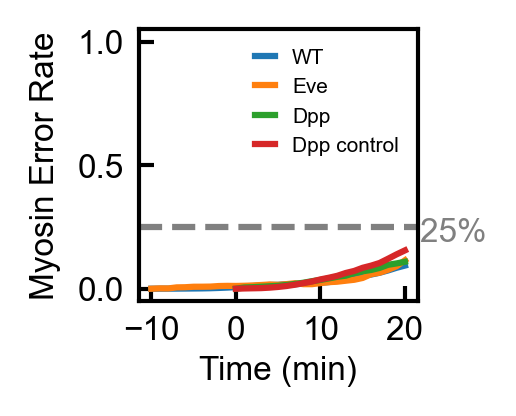

In [28]:
#Define mask that crops anterior/posterior poles
mask = np.s_[..., 15:-15, 15:-15]

def residual(u, v):
    c = np.prod(u.shape) // (u.shape[0] * u.shape[-2] * u.shape[-1])
    u = u[mask].reshape([u.shape[0], c, -1])
    v = v[mask].reshape(u.shape)
    
    u2 = np.power(u, 2).sum(axis=1)
    v2 = np.power(v, 2).sum(axis=1)
    uavg = u2.mean(axis=1, keepdims=True)
    vavg = v2.mean(axis=1, keepdims=True)
        
    res = uavg * v2 + vavg * u2 - 2 * np.sqrt(uavg * vavg) * np.einsum('bix,bix->bx', u, v)
    res = res / (2 * uavg * vavg)
    
    return res.mean(axis=1)

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(1.2, 1.2))

for data in [wt, eve, dpp, dppC]:
    m0, m1 = data['m0'], data['m1']
    v0, v1 = data['v0'], data['v1']
    time = data['t0']

    ax.plot(time, residual(m0, m1), label=data['folder'])

ax.axhline(0.25, zorder=0, color='grey', linestyle='--')
ax.text(1.01, 0.25, '25%', transform=ax.transAxes,
        color='grey', va='center', ha='left')
ax.set_ylabel('Myosin Error Rate', labelpad=4)
ax.set_ylim([-0.05, 1.05])
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('Time (min)', labelpad=2)
ax.set_xticks([-10, 0, 10, 20])
ax.legend(fontsize=5)

#fig.savefig('Forecasting/ErrorRatePlot.svg', bbox_inches='tight')

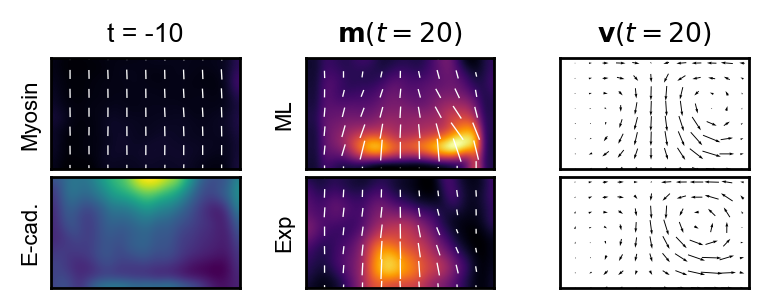

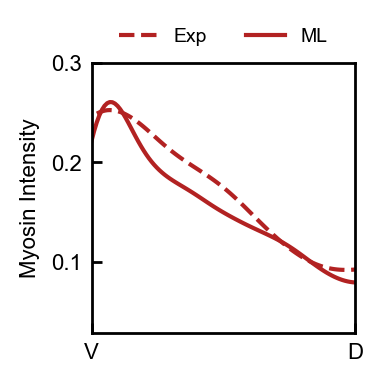

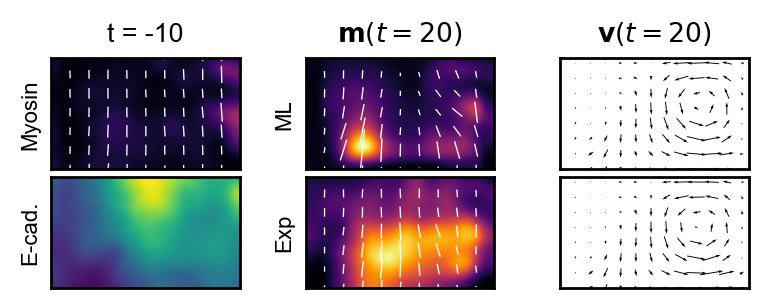

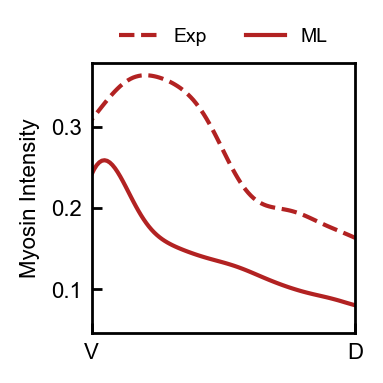

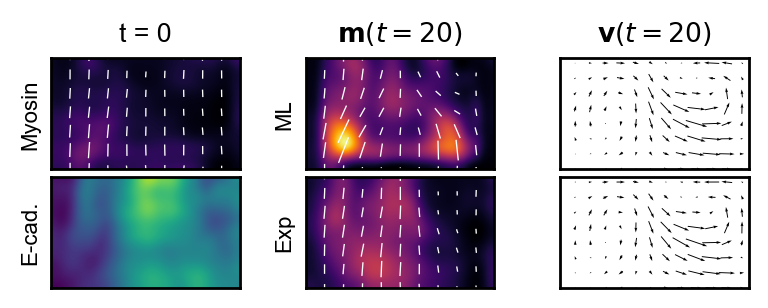

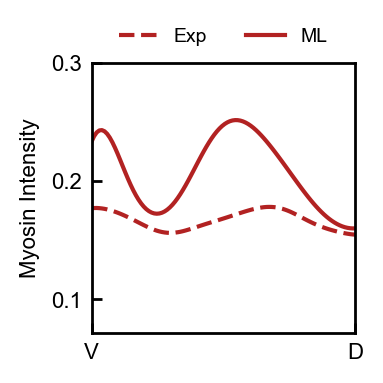

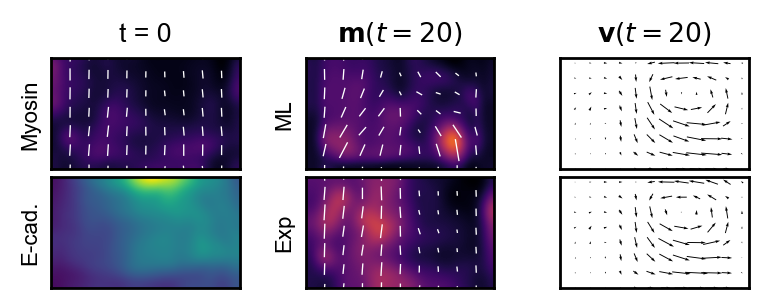

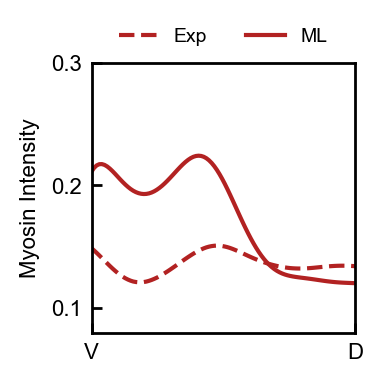

In [33]:
from utils.plot_utils import *

midpoint = 118

def get_cut(z, N0=80, N1=120):
    '''
    Return the average DV cut between N0 and N1 along the AP axis
    '''
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
    cut = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut


for data in [wt, eve, dpp, dppC]:

    fig, ax = plt.subplots(2, 3, dpi=200,
                           figsize=(4.5, 2),
                           constrained_layout=True)

    mii = np.linalg.norm(data['m0'], axis=1)
    mmax = np.mean(mii) + 5*np.std(mii)

    plot_tensor2D(ax[0, 0], data['m0'][0], vmax=mmax)
    color_2D(ax[1, 0], data['c0'])

    ax[0,0].set_title(f't = {data["t0"][0]}')
    ax[0,0].set_ylabel('Myosin')
    ax[1,0].set_ylabel('E-cad.')

    plot_tensor2D(ax[0, 1], data['m1'][-1])#, vmax=mmax)
    plot_tensor2D(ax[1, 1], data['m0'][-1], vmax=mmax)

    ax[0,1].set_title('$\\mathbf{m}(t = ' + f'{data["t0"][-1]})$')
    ax[0,1].set_ylabel('ML')
    ax[1,1].set_ylabel('Exp')

    plot_vector2D(ax[0, 2], data['v1'][-1], skip=16)
    plot_vector2D(ax[1, 2], data['v0'][-1], skip=16)

    ax[0,2].set_title('$\\mathbf{v}(t = ' + f'{data["t0"][-1]})$')

    fig.subplots_adjust(wspace=0.35, hspace=-0.35)
    fig.savefig(f'Forecasting_{data["folder"]}.svg', bbox_inches='tight')


    '''
    fig, ax = plt.subplots(1, 1, dpi=200, figsize=(1.8, 2), constrained_layout=True, squeeze=False)
    ax[0,0].plot(data['t0'], np.linalg.norm(data['v0'], axis=1).mean(axis=(1,2)), color='black', linestyle='--', label='Exp')
    ax[0,0].plot(data['t0'], np.linalg.norm(data['v1'], axis=1).mean(axis=(1, 2)), color='black',linestyle='-', label='ML')
    ax[0,0].set_ylim([0, 4.5])
    ax[0,0].set_yticks([0, 2, 4])
    ax[0,0].set_xlim([-10, 20])
    ax[0,0].set_xticks([-10, 0, 10, 20])
    ax[0,0].set_ylabel('Flow ($\mu$m / min)')
    ax[0,0].set_xlabel('Time (min)')
    ax[0,0].legend(handlelength=2, bbox_to_anchor=[0.5, 1], loc='lower center', ncol=2)
    '''
        
    data['cut0'] = get_cut(data['m0'][-1])[:118]
    data['cut1'] = get_cut(data['m1'][-1])[:118]
        
    fig, ax = plt.subplots(1, 1, dpi=200, figsize=(1.8, 1.8), constrained_layout=True, squeeze=False)
    
    dv = np.linspace(dv_min, dv_midpoint, 118)
    vfc = 40

    ax[0,0].plot(dv, data['cut0'], color='firebrick', linestyle='--', label='Exp')
    ax[0,0].plot(dv, data['cut1'], color='firebrick', linestyle='-', label='ML')

    #ax[0,0].set_ylim([0, 4.5])
    #ax[0,0].set_yticks([0, 2, 4])
    ax[0,0].set_yticks([0.1, 0.2, 0.3])
    ax[0,0].set_xlim([vfc, dv_midpoint])
    ax[0,0].set_xticks([vfc, dv_midpoint])
    ax[0,0].set_xticklabels(['V', 'D'])
    ax[0,0].set_ylabel('Myosin Intensity')
    ax[0,0].legend(handlelength=2, bbox_to_anchor=[0.5, 1], loc='lower center', ncol=2)

    fig.savefig(f'Comparison_{data["folder"]}.svg', bbox_inches='tight')


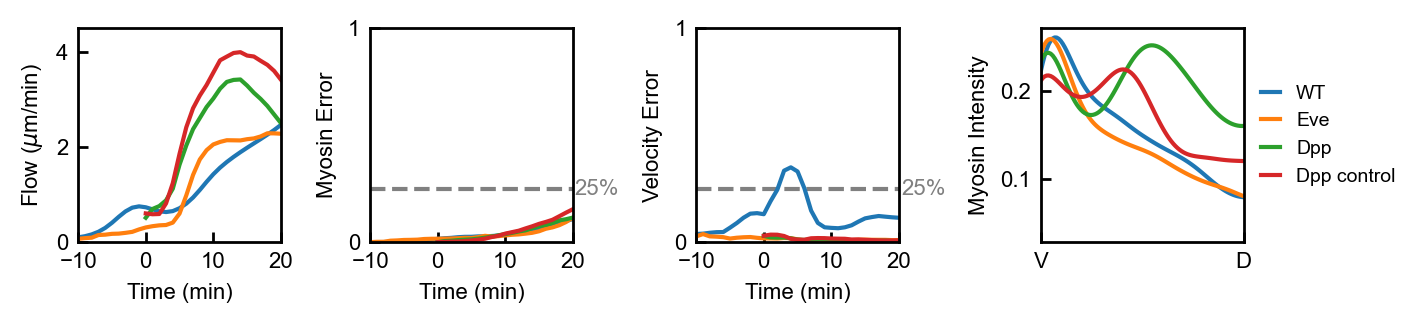

In [30]:
fig, ax = plt.subplots(1, 4, dpi=200, constrained_layout=True, figsize=(7,1.5))

dv = np.linspace(dv_min, dv_midpoint, 118)
vfc = 40

for data in [wt, eve, dpp, dppC]:
    ax[0].plot(data['t0'], np.linalg.norm(data['v1'], axis=1).mean(axis=(1, 2)))
    ax[1].plot(data['t0'], residual(data['m0'], data['m1']).mean(axis=(1, 2)))
    ax[2].plot(data['t0'], residual(data['v0'], data['v1']).mean(axis=(1, 2)))
    ax[3].plot(dv, data['cut1'], label=data['folder'])
    
ax[0].set(
    ylim=[0, 4.5],
    yticks=[0, 2, 4],
    ylabel='Flow ($\mu$m/min)',
    xlim=[-10, 20],
    xticks=[-10, 0, 10, 20],
    xlabel='Time (min)',
)
ax[1].set(
    ylim=[0, 1],
    yticks=[0, 1],
    ylabel='Myosin Error',
    xlim=[-10, 20],
    xticks=[-10, 0, 10, 20],
    xlabel='Time (min)',
)
ax[1].axhline(0.25, zorder=0, color='grey', linestyle='--')
ax[1].text(1.01, 0.25, '25%', transform=ax[1].transAxes,
        color='grey', va='center', ha='left')

ax[2].set(
    ylim=[0, 1],
    yticks=[0, 1],
    ylabel='Velocity Error',
    xlim=[-10, 20],
    xticks=[-10, 0, 10, 20],
    xlabel='Time (min)',
)
ax[2].axhline(0.25, zorder=0, color='grey', linestyle='--')
ax[2].text(1.01, 0.25, '25%', transform=ax[2].transAxes,
        color='grey', va='center', ha='left')

ax[3].set(
    ylabel='Myosin Intensity',
    xlim=[vfc, dv_midpoint],
    xticks=[vfc, dv_midpoint],
    xticklabels=['V', 'D'],
)

ax[3].legend(loc='center left', bbox_to_anchor=[1, 0.5])

#fig.savefig('Summary.svg', bbox_inches='tight')